# Multi Index

The reason that the MultiIndex matters is that it can allow you to do grouping, selection, and reshaping operations. As you will see in later sections, you can find yourself working with hierarchically-indexed data without creating a MultiIndex explicitly yourself.

Topics Reviewed:

- DataFrame structure with Multi-index: index, columns, axis, levels
- Multi-index creation `.from_arrays()`, `.from_tuples()`, `.from_product()`
- Indexing and Slicing with Multi-index `.loc[<tuple1>,<tuple2>]`,`.loc[<tuple of lists>]` (or slicing), `.loc[<list of tuple>]`,`.loc[<label_on_first_level>]`,`df.loc(axis = 0)[]`, `.xs()`
- Function of Interest about Multi-index
    - Important: `.reindex()`, .`reset_index()`, `.set_index()`, `.align()`
    - Extras:` swaplevel()`, `reorder_levels()`, `index.set_names()`

In [175]:
import pandas as pd
import numpy as np

np.random.seed(0)

In [176]:
## Handy function
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Multi-Index in a DataFrame

Multi-indexing is a powerful feature in `DataFrame`s that allows to work 
efficiently with multi-dimensional data. 

Instead of using multiple axes like in Numpy arrays, DataFrames utilize 
`index` and `columns` labels that are multi-indexes with different `levels`. 
    
This approach eliminates the need for multiple axes, simplifying the 
representation of multi-dimensional data in a two-dimensional `DataFrame`. 

Using Multi-index, we can identify distinct components within a DataFrame:

1. `index` are row label indentifiers
2. `columns` are column label indentifier
3. `axis` indicates the current dimension. 
    - `axis = 0` the index dim
    - `axis = 1` the columns dim
4. `levels` indicates the different layers of a multi-index. Note each level can be named.

<img src="./assets/imgs/multi_index_structure.png" width="500"/>

In [177]:
index = pd.MultiIndex.from_product(
    [["foo", "bar", "caz"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","weight","height"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.random.randint(10, size = (6,6)),
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age weight height age weight height
word number                                    
foo  one      5      0      3   3      7      9
     two      3      5      2   4      7      6
bar  one      8      8      1   6      7      7
     two      8      1      5   9      8      9
caz  one      4      3      0   3      5      0
     two      2      3      8   1      3      3

In [178]:
print("Axes:", df.axes)
print("Row Levels: ", df.index.levels)
print("Column Levels: ", df.columns.levels)

Axes: [MultiIndex([('foo', 'one'),
            ('foo', 'two'),
            ('bar', 'one'),
            ('bar', 'two'),
            ('caz', 'one'),
            ('caz', 'two')],
           names=['word', 'number']), MultiIndex([('A',    'age'),
            ('A', 'weight'),
            ('A', 'height'),
            ('B',    'age'),
            ('B', 'weight'),
            ('B', 'height')],
           names=['letter', 'feature'])]
Row Levels:  [['bar', 'caz', 'foo'], ['one', 'two']]
Column Levels:  [['A', 'B'], ['age', 'height', 'weight']]


## Multi Index Creation

It is possible to create multindex in diferent ways. The most relevant are the 
folliwing.

1. `pd.MultiIndex.from_arrays()` creates multi-index from the pair-wise combination between two arrays.
2. `pd.MultiIndex.from_tuples()` creates multi-index from each tuple in a list of tuples.
3. `pd.MultiIndex.from_product()` creates multi-index between the cross combination between two arrays.

**NOTE:** it is possible to provided a list of list (or arrays) to the `index` paramater in `pd.DataFrame()` to create the multi-index similar to a `.from_arrays()` function.

**NOTE:** it is also possible to create a multi-index from a `DataFrame` with `pd.MultiIndex.from_frame()`

In [179]:
# 1. Multi-index from arrays
index = pd.MultiIndex.from_arrays(
    [
        ["one", "one", "two", "two", "three", "three"],
        ["foo", "bar", "foo", "bar", "foo", " bar"]
     ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo   0
      bar   1
two   foo   2
      bar   3
three foo   4
       bar  5

In [180]:
# NOTE: Creating a multi-index directly in the DataFrame
df = pd.DataFrame(np.arange(6),
                  index = [ ["one", "one", "two", "two", "three", "three"],
                            ["foo", "bar", "foo", "bar", "foo", " bar"]])
df

0
one   foo   0
      bar   1
two   foo   2
      bar   3
three foo   4
       bar  5

In [181]:
#2. Multi-index from tuples
index = pd.MultiIndex.from_tuples(
    [
        ("one","foo"),
        ("one","bar"),
        ("two","foo"),
        ("two","bar"),
        ("three","foo"),
        ("three","bar")
    ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo  0
      bar  1
two   foo  2
      bar  3
three foo  4
      bar  5

In [182]:
# 3. Multi-index from product
index = pd.MultiIndex.from_product(
    [
        ["one", "two", "three"],
        ["foo", "bar"]
    ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo  0
      bar  1
two   foo  2
      bar  3
three foo  4
      bar  5

## Indexing and Slicing with Multi Index

There are different ways for indexing a `DataFrame` with multi-index. The main idea is that
you can identify a particular multi-index row (or column) by a tuple containing the levels required

`(level0, level1, level2, ...)`

**NOTE:** `level0`, `level1`, and `level2` are the label indentifiers on each level, not the level names.

In such way, you can perform the following indexing:

1. `.loc[(level0, level1,)]` takes the row specified by `level0` and `level1` on index.
2. `.loc[:,(level0, level1,)]` takes the column specified by `level0` and `level1` on columns.
3. `.loc[(level0,level1),(level0,level1)]` takes the specific cell specified by `level0` and `level1` on index and `level0` and `level1` on columns.

<img src="./assets/imgs/multi_index_basic_indexing.png" width="600"/>

In [183]:
index = pd.MultiIndex.from_product(
    [["foo", "bar", "caz"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","weight","height"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.random.randint(10, size = (6,6)),
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age weight height age weight height
word number                                    
foo  one      3      7      0   1      9      9
     two      0      4      7   3      2      7
bar  one      2      0      0   4      5      5
     two      6      8      4   1      4      9
caz  one      8      1      1   7      9      9
     two      3      6      7   2      0      3

In [184]:
# 1. indexing specific row
df.loc[("foo","one")]

letter  feature
A       age        3
        weight     7
        height     0
B       age        1
        weight     9
        height     9
Name: (foo, one), dtype: int64

In [185]:
# 2. indexing specific col
df.loc[:, ("A", "age")]

word  number
foo   one       3
      two       0
bar   one       2
      two       6
caz   one       8
      two       3
Name: (A, age), dtype: int64

In [186]:
# 4. indexing specific cell (row, col combination)
df.loc[("bar","two"),("B","height")]

9

### List, Tuples and Slicing

As common indexing, you can take values calling a **list of tuples**. Nonetheless, the multi-index also accepts
a **tuple of list**, which must not be confused with the list of tuples. 

1. `.loc[<list of tuple>]` takes the rows specified by the list of tuples on index.
2. `.loc[<tuple of lists>,:]` takes all rows resulting from the cross combination between the lists labels on index.
3. `.loc[(<tuple1>:<tuple2)]` (slicing) takes the rows from `tuple1` to `tuple2`. It is practically a list of tuples by comprenhension, similar to numpy. However, the index or columns labels **must be sorted in order to slice it**.

**NOTE**: you can also apply the previous techniques in columns.

<img src="./assets/imgs/multi_index_tuples_list_slicing.png" width="600"/>

In [187]:
#NOTE: the column labels are unsorted, then the slicing will return an error
#For that reason, we sorted the labels first
df = df.sort_index(axis=1)
df

letter        A                 B              
feature     age height weight age height weight
word number                                    
foo  one      3      0      7   1      9      9
     two      0      7      4   3      7      2
bar  one      2      0      0   4      5      5
     two      6      4      8   1      9      4
caz  one      8      1      1   7      9      9
     two      3      7      6   2      3      0

In [188]:
# 1. Indexing list of tuples
result = df.loc[[("foo","one"),("bar","two")]]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 two 
 6 
 4 
 8 
 1 
 9 
 4

In [189]:
# 2. Indexing tuple of lists
# NOTE: it takes the cross combination betweewn both lists
result = df.loc[(["foo","bar"],["one","two"]),:]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4

In [190]:
#3. Indexing using slicing on tuples
#NOTE: it will take columns from ("A","height") to ("B","age")
result = df.loc[:,("A","height"):("B","age")]
display_side_by_side(df,result)


letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 height 
 weight 
 age 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 0 
 7 
 1 
 
 
 two 
 7 
 4 
 3 
 
 
 bar 
 one 
 0 
 0 
 4 
 
 
 two 
 4 
 8 
 1 
 
 
 caz 
 one 
 1 
 1 
 7 
 
 
 two 
 7 
 6 
 2

### Partial Selection

Let say we are only interested in **picking a particular label in a given level** (not the tuple combination). To do that, you can select data by a “partial” label identifying a subgroup in the data. There are different ways to do it:

1. `.loc[level0]` selects all the rows specified by an indentifier only in the first level on index. However, this only works on the first level. Note you can also use slicing with this technique.
2. `.loc(axis=0)[<level0>,<level1>,<level2>, ...]` choses an axis, and then the content within the brackets (`[]`) works as you were indexing only in the levels of that axis.
3. `.xs(<label_on_level>, level = <level_name> , axis = 0)` choses level_name and axis, and then filters a particular label in that level and axis

**NOTE:** the three methods work for both index and column labels.

<img src="./assets/imgs/multi_index_partial_selection.png" width="600"/>

**NOTE:** it is also possible to make partial selection with the previous methods of list, tuples, and slicing. In fact, you can use a combination of tuples, list of tuples, tuple of lists, or slicing together with the first option.

**NOTE:** There are other metods that uses `slice()` or `pd.IndexSlice` for indexing the `DataFrame`. However, those methods are out of the scope of this tutorial.

In [191]:
# 1. indexing an specific label on level 0
# NOTE: we can also use slicing like "bar":"caz", but we first need to sort the index
result = df.loc["foo"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 number 
 
 
 
 
 
 
 
 
 
 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2

In [193]:
# 1. indexing an specific label on level 0 (on columns)
result = df.loc[:,"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 two 
 0 
 7 
 4 
 
 
 bar 
 one 
 2 
 0 
 0 
 
 
 two 
 6 
 4 
 8 
 
 
 caz 
 one 
 8 
 1 
 1 
 
 
 two 
 3 
 7 
 6

In [192]:
# 2. indexing an specific label on any level
# NOTE: here we pick the label ="one" in the level 2
result = df.loc(axis=0)[:,"one"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9

In [168]:
# 3. indexing an specific label on any level (USING .xs function)
# NOTE: here we pick the label ="one" in the level 2
# NOTE: it removes the level
result = df.xs("one", level="number")
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 
 
 
 
 
 
 
 
 
 
 foo 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 caz 
 8 
 1 
 1 
 7 
 9 
 9

In [195]:
# Tuple and first option
result = df.loc[("foo","one"),"A"]
result

feature
age       3
height    0
weight    7
Name: (foo, one), dtype: int64

In [196]:
# List of tuples and first option
result = df.loc[[("foo","one"), ("bar","one")],"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 bar 
 one 
 2 
 0 
 0

In [197]:
# Tuple of lists and first option
result = df.loc[(["foo","bar"], ["one","two"]),"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 two 
 0 
 7 
 4 
 
 
 bar 
 one 
 2 
 0 
 0 
 
 
 two 
 6 
 4 
 8

In [198]:
# slicing and first option
result = df.loc["foo", ("A","age"):("B","age")]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 
 
 number 
 
 
 
 
 
 
 
 
 one 
 3 
 0 
 7 
 1 
 
 
 two 
 0 
 7 
 4 
 3

## Multi-index Functions of Interest

The following are some important functions that we could use when working with multi-index:

1. `set_index()` and `reset_index()` can work together
2. `reindex()` (can also be used for broadcasting similar to `align()`)
3. `swaplevel()` and `reorder_levels()`
4. `rename`, `rename_axis`, `index.set_names`, `.set_axis()`


In [203]:
index = pd.MultiIndex.from_product(
    [["bar", "caz","foo"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","height","weight"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.arange(36).reshape(6,6) ,
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age height weight age height weight
word number                                    
bar  one      0      1      2   3      4      5
     two      6      7      8   9     10     11
caz  one     12     13     14  15     16     17
     two     18     19     20  21     22     23
foo  one     24     25     26  27     28     29
     two     30     31     32  33     34     35

### `set_index()` and `reset_index()`

- `set_index(keys = <column or columns names>)` sets the index using the column (or columns).
- `reset_index(level= <level or list of levels>)` resets the index (or a level in multi-index) and use the default index instead. 
    - By default, it reset all the levels in a multi-index.
    - When define a level, the other levels remain in the index.

In [213]:
# 1. use two columns to set index
result = df.set_index([("A","age"), ("B","age")])
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 height 
 weight 
 height 
 weight 
 
 
 (A, age) 
 (B, age) 
 
 
 
 
 
 
 
 
 0 
 3 
 1 
 2 
 4 
 5 
 
 
 6 
 9 
 7 
 8 
 10 
 11 
 
 
 12 
 15 
 13 
 14 
 16 
 17 
 
 
 18 
 21 
 19 
 20 
 22 
 23 
 
 
 24 
 27 
 25 
 26 
 28 
 29 
 
 
 30 
 33 
 31 
 32 
 34 
 35

In [214]:
# 2. reset index from multi-index
result = df.reset_index(level="number")
display_side_by_side(df, result)
print(result.columns)
# NOTE: the multi-index tuple for the new column is ('number', '')

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 letter 
 number 
 A 
 B 
 
 
 feature 
 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 bar 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 foo 
 two 
 30 
 31 
 32 
 33 
 34 
 35

MultiIndex([('number',       ''),
            (     'A',    'age'),
            (     'A', 'height'),
            (     'A', 'weight'),
            (     'B',    'age'),
            (     'B', 'height'),
            (     'B', 'weight')],
           names=['letter', 'feature'])


In [216]:
# by default reset all the levels
result = df.reset_index()
display_side_by_side(df, result)


letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 letter 
 word 
 number 
 A 
 B 
 
 
 feature 
 
 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 
 
 0 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 1 
 bar 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 2 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 3 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 4 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 5 
 foo 
 two 
 30 
 31 
 32 
 33 
 34 
 35

### `reindex()`

`.reindex(labels)` returns a new Series or DataFrame with the indexes
specified in `labels`. 

However, if the labels in `labels` parameter there are not in the previous `index` 
the values will be filled with NaN. 

In that way, we could use `.reindex()` as a selector similar to list of tuples indexing.

broadcast
`.reindex(labels, axis, index, columns, labels, fill_value)`

In [217]:
df

letter        A                 B              
feature     age height weight age height weight
word number                                    
bar  one      0      1      2   3      4      5
     two      6      7      8   9     10     11
caz  one     12     13     14  15     16     17
     two     18     19     20  21     22     23
foo  one     24     25     26  27     28     29
     two     30     31     32  33     34     35

In [219]:
df.reindex(labels=[("bar","one"),("caz","two"),("foo","three")])

letter          A                   B              
feature       age height weight   age height weight
word number                                        
bar  one      0.0    1.0    2.0   3.0    4.0    5.0
caz  two     18.0   19.0   20.0  21.0   22.0   23.0
foo  three    NaN    NaN    NaN   NaN    NaN    NaN

In [221]:
df.reindex(labels=[("bar","one"),("caz","two"),("foo","three")])

KeyError: 'Level letter not found'

In [39]:
# reset_index() behavior
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                   'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                   'C': [1, 2, 3, 4, 5, 6, 7, 8],
                   'D': [10, 20, 30, 40, 50, 60, 70, 80]})

df = df.set_index(['A', 'B'])

df

C   D
A   B           
foo one    1  10
bar one    2  20
foo two    3  30
bar three  4  40
foo two    5  50
bar two    6  60
foo one    7  70
    three  8  80

In [40]:
df = df.reset_index()
df

,A,B,C,D
0,foo,one,1,10
1,bar,one,2,20
2,foo,two,3,30
3,bar,three,4,40
4,foo,two,5,50
5,bar,two,6,60
6,foo,one,7,70
7,foo,three,8,80


In [44]:
# order of combinations in a multiple index given by codes parameter
midx = pd.MultiIndex(
    levels=[["zero", "one"], ["x", "y"]], codes=[[1, 1, 0, 0], [1, 0, 1, 0]]
)
midx

# 1, 1, 0, 0 indicates the order of the first level
# zero is in the 0 position in ["zero", "one"]
# one is in the 1 position in ["zero", "one"]
# Then 1, 1, 0, 0 returns the order of labels as
# one
# one
# zero
# zero

# 1, 0, 1, 0 indicates the order of the label "zero" and "one"
# x is in the 0 position in ["x", "y"]
# y is in the 1 position in ["x", "y"]
# Then 1, 0, 1, 0 returns the order of labels as
# y
# x
# y
# x

# both together return
# one y
# one x
# zero y
# zero x


MultiIndex([( 'one', 'y'),
            ( 'one', 'x'),
            ('zero', 'y'),
            ('zero', 'x')],
           )

In [45]:
midx = pd.MultiIndex(
    levels=[["zero", "one"], ["x", "y"]], codes=[[1, 0, 1, 0], [1, 0, 1, 0]]
)
midx

MultiIndex([( 'one', 'y'),
            ('zero', 'x'),
            ( 'one', 'y'),
            ('zero', 'x')],
           )

In [47]:
df = pd.DataFrame(np.random.randn(4, 2), index=midx)
df

,,0,1
one,y,-0.472006,0.503593
zero,x,-1.748592,-1.293128
one,y,0.424005,1.315597
zero,x,-1.252612,0.335079


#### Alignment and Broadcast with `reindex()` or `align()`

In my words, **aligment** is from two DataFrames with different shapes return two 
new DataFrames that share the same shape. This is gotten by completing 
the rows or cols that are missing in each other DataFrame (commonly it is 
completing with NaN values)

In my words, **broadcast** will be repeated a given value along some rows or
cols

In my words, **aligment + broadcasting** will be instead of completing with
NaN values broadcast some values in the missing spaces.


In [48]:
midx = pd.MultiIndex(
    levels=[["zero", "one"], ["x", "y"]], codes=[[1, 1, 0, 0], [1, 0, 1, 0]]
)
df = pd.DataFrame(np.random.randn(4, 2), index=midx)
df

0         1
one  y -0.183850  0.691048
     x  1.223373 -1.808746
zero y  1.137095 -0.347095
     x  1.180646  1.145676

In [49]:
# getting the mean per each index in level 0
df2 = df.groupby(level=0).mean()
df2

,0,1
one,0.519761,-0.558849
zero,1.158870,0.399290


In [53]:
# broadcasting + alingment with reindex
# level = 0 indicates to broadcast the values on level 0
# keeping the df.index shape
df2.reindex(df.index, level=0)

# note you need to reassign to df2 to save the changes

0         1
one  y  0.519761 -0.558849
     x  0.519761 -0.558849
zero y  1.158870  0.399290
     x  1.158870  0.399290

In [54]:
df2

,0,1
one,0.519761,-0.558849
zero,1.158870,0.399290


In [55]:
# alignment + broadcasting using .align()
# level = 0 similarly to the previous case indicates broadcasting along the 
# level 0
df_aligned, df2_aligned = df.align(df2, level=0)
df2_aligned

# TODO: probably I need to explain better align

0         1
one  y  0.519761 -0.558849
     x  0.519761 -0.558849
zero y  1.158870  0.399290
     x  1.158870  0.399290

In [56]:
df_aligned

0         1
one  y -0.183850  0.691048
     x  1.223373 -1.808746
zero y  1.137095 -0.347095
     x  1.180646  1.145676

In [57]:
#swaping levels
df.swaplevel(0, 1, axis=0)

,,0,1
y,one,-0.183850,0.691048
x,one,1.223373,-1.808746
y,zero,1.137095,-0.347095
x,zero,1.180646,1.145676


In [58]:
# reordering level generalizes swaplevel
df.reorder_levels([1,0], axis= 0)


,,0,1
y,one,-0.183850,0.691048
x,one,1.223373,-1.808746
y,zero,1.137095,-0.347095
x,zero,1.180646,1.145676


In [60]:
df

0         1
one  y -0.183850  0.691048
     x  1.223373 -1.808746
zero y  1.137095 -0.347095
     x  1.180646  1.145676

In [59]:
# you can do the same with reindex (I thnink)
# NOOOO -> to use reindex you have to keep into account the order of levels

# REMEMBER: it will be important to have a graph showing the following
# index, columns
# levels,
# axis
# names
new_index = [["y","x"],["one","zero"]]
new_index = pd.MultiIndex(new_index, codes=[[0,1,0,1],[0,0,1,1]])
df.reindex(new_index)

,,0,1
y,one,NaN,NaN
x,one,NaN,NaN
y,zero,NaN,NaN
x,zero,NaN,NaN


## Database-style DataFrame (`join()` and `merge()`)
Pandas has full-featured, high performance in-memory join operations idiomatically very similar to relational databases like SQL. 

## `merge()`

Accepts a left and right `DataFrame` or `named Series` objects

You can use it as 

`pd.merge(df1, df2)` or `df1.merge(df2)`

The related `join()` method, uses merge internally for the index-on-index (by default) and column(s)-on-index join.

In [3]:
left = pd.DataFrame(
    {
        "key1": ["K0", "K0", "K1", "K2"],
        "key2": ["K0", "K1", "K0", "K1"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }
)
left

,key1,key2,A,B
0,K0,K0,A0,B0
1,K0,K1,A1,B1
2,K1,K0,A2,B2
3,K2,K1,A3,B3


In [5]:
right = pd.DataFrame(
    {
        "key1": ["K0", "K1", "K1", "K2"],
        "key2": ["K0", "K0", "K0", "K0"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    }
)
right

,key1,key2,C,D
0,K0,K0,C0,D0
1,K1,K0,C1,D1
2,K1,K0,C2,D2
3,K2,K0,C3,D3


In [6]:
result = pd.merge(left, right, on=["key1", "key2"])
result

,key1,key2,A,B,C,D
0,K0,K0,A0,B0,C0,D0
1,K1,K0,A2,B2,C1,D1
2,K1,K0,A2,B2,C2,D2


In [14]:
result = pd.merge(left, right, on=["key1", "key2"], how="left")
display_side_by_side(left, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 NaN 
 NaN 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 3 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 4 
 K2 
 K1 
 A3 
 B3 
 NaN 
 NaN

In [15]:
result = pd.merge(left, right, on=["key1", "key2"], how="right")
display_side_by_side(right, result)

key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 NaN 
 NaN 
 C3 
 D3

In [18]:
result = pd.merge(left, right, on=["key1", "key2"], how="outer")
display_side_by_side(left, right, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 NaN 
 NaN 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 3 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 4 
 K2 
 K1 
 A3 
 B3 
 NaN 
 NaN 
 
 
 5 
 K2 
 K0 
 NaN 
 NaN 
 C3 
 D3

In [20]:
result = pd.merge(left, right, how="cross")
display_side_by_side(left, right, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1_x 
 key2_x 
 A 
 B 
 key1_y 
 key2_y 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K0 
 K0 
 A0 
 B0 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K0 
 K0 
 A0 
 B0 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K0 
 K0 
 A0 
 B0 
 K2 
 K0 
 C3 
 D3 
 
 
 4 
 K0 
 K1 
 A1 
 B1 
 K0 
 K0 
 C0 
 D0 
 
 
 5 
 K0 
 K1 
 A1 
 B1 
 K1 
 K0 
 C1 
 D1 
 
 
 6 
 K0 
 K1 
 A1 
 B1 
 K1 
 K0 
 C2 
 D2 
 
 
 7 
 K0 
 K1 
 A1 
 B1 
 K2 
 K0 
 C3 
 D3 
 
 
 8 
 K1 
 K0 
 A2 
 B2 
 K0 
 K0 
 C0 
 D0 
 
 
 9 
 K1 
 K0 
 A2 
 B2 
 K1 
 K0 
 C1 
 D1 
 
 
 10 
 K1 
 K0 
 A2 
 B2 
 K1 
 K0 
 C2 
 D2 
 
 
 11 
 K1 
 K0 
 A2 
 B2 
 K2 
 K0 
 C3 
 D3 
 
 
 12 
 K2 
 K1 
 A3 
 B3 
 K0 
 K0 
 C0 
 D0 
 
 
 13 
 K2 
 K1 
 A3 
 B3 
 K1 
 K0 
 C1 
 D1 
 
 
 14 
 K2 
 K1 
 A3 
 B3 
 K1 
 K0 
 C2 
 D2 
 
 
 15 
 K2 
 K1 
 A3 
 B3 
 K2 
 K0 
 C3 
 D3

In [21]:
ser = pd.Series(
    ["a", "b", "c", "d", "e", "f"],
    index=pd.MultiIndex.from_arrays(
        [["A", "B", "C"] * 2, [1, 2, 3, 4, 5, 6]], names=["Let", "Num"]
    ),
)
ser

Let  Num
A    1      a
B    2      b
C    3      c
A    4      d
B    5      e
C    6      f
dtype: object

In [22]:
ser.reset_index()

,Let,Num,0
0,A,1,a
1,B,2,b
2,C,3,c
3,A,4,d
4,B,5,e
5,C,6,f


**Warning:** Joining / merging on duplicate keys can cause a returned frame that is the multiplication of the row dimensions, which may result in memory overflow. It is the user’ s responsibility to manage duplicate values in keys before joining large DataFrames.

In [24]:
left = pd.DataFrame({"A": [1, 2], "B": [2, 2]})

right = pd.DataFrame({"A": [4, 5, 6], "B": [2, 2, 2]})

result = pd.merge(left, right, on="B", how="outer")

display_side_by_side(left, right, result)

# este ejercicio me hace dudar todo lo que entendi antes

A 
 B 
 
 
 
 
 0 
 1 
 2 
 
 
 1 
 2 
 2 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 0 
 4 
 2 
 
 
 1 
 5 
 2 
 
 
 2 
 6 
 2 
 
 
 
 
 
 
 A_x 
 B 
 A_y 
 
 
 
 
 0 
 1 
 2 
 4 
 
 
 1 
 1 
 2 
 5 
 
 
 2 
 1 
 2 
 6 
 
 
 3 
 2 
 2 
 4 
 
 
 4 
 2 
 2 
 5 
 
 
 5 
 2 
 2 
 6

In [25]:

result = pd.merge(left, right, on="B", how="inner")

display_side_by_side(left, right, result)

A 
 B 
 
 
 
 
 0 
 1 
 2 
 
 
 1 
 2 
 2 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 0 
 4 
 2 
 
 
 1 
 5 
 2 
 
 
 2 
 6 
 2 
 
 
 
 
 
 
 A_x 
 B 
 A_y 
 
 
 
 
 0 
 1 
 2 
 4 
 
 
 1 
 1 
 2 
 5 
 
 
 2 
 1 
 2 
 6 
 
 
 3 
 2 
 2 
 4 
 
 
 4 
 2 
 2 
 5 
 
 
 5 
 2 
 2 
 6

If a string matches both a column name and an index level name, then a warning is issued and the column takes precedence. This will result in an ambiguity error in a future version.

**Note**: the non-unique keys problem that I didn't understand happens because
there are overlapping cases where for example

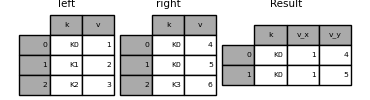

If we want to 'inner' merge using k as key we encounter overlapping in the values
of v because

1. left has K0 1
2. right has K0 3 and K0 4

Then, the overlapping is solve by adding two columns at the resultin merged df
as v_x and v_y

v_x for the left values of column v and v_y for the right values of column v

In [29]:
df1 = pd.DataFrame({"v": [1, 2, 3]}, index=["K0", "K1", "K2"])
df2 = pd.DataFrame({"v": [4, 5, 6]}, index=["K0", "K0", "K3"])
df3 = pd.DataFrame({"v": [7, 8, 9]}, index=["K1", "K1", "K2"])

result = df1.join([df2, df3])

display_side_by_side(df1, df2, df3, result)


,v
K0,1
K1,2
K2,3
,v
K0,4
K0,5
K3,6
,v
K1,7
K1,8


In [31]:
#the idea of combine_first is to have two data frames that are similar in the sense
# that they have same index and columns (not necessarily all of them)
# and you want to "patch" or fill some nan values from left with the values
# from right.

df1 = pd.DataFrame(
    [[np.nan, 3.0, 5.0], [-4.6, np.nan, np.nan], [np.nan, 7.0, np.nan]]
)


df2 = pd.DataFrame([[-42.6, np.nan, -8.2], [-5.0, 1.6, 4]], index=[1, 2])

result = df1.combine_first(df2)

display_side_by_side(df1, df2, result)

,0,1,2
0,NaN,3.0,5.0
1,-4.6,NaN,NaN
2,NaN,7.0,NaN
,0,1,2
1,-42.6,NaN,-8.2
2,-5.0,1.6,4.0
,0,1,2
0,NaN,3.0,5.0
1,-4.6,NaN,-8.2
2,-5.0,7.0,4.0


In [33]:
# related method that alterate the NaN values in place
# but replace all the values from right into the left structure
df1.update(df2)
df1

,0,1,2
0,NaN,3.0,5.0
1,-42.6,NaN,-8.2
2,-5.0,1.6,4.0
